<a href="https://colab.research.google.com/github/alexz949/CSC374_Project/blob/main/StockPredictionLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Data**


In [ ]:
# Obtain data from yfinance
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Define the list of top 100 company tickers, use only AAPL for now
tickers = ['AAPL']

# Set the date range
start_date = '1994-11-06'
end_date = datetime.today().strftime('%Y-%m-%d')

# Loop through each ticker and download data
for ticker in tickers:
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    # Reset column names to avoid mismatched headers
    data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    # Reset the index to a new "Date" column and keep only the date part
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.date  # Convert DateTime to just date (YYYY-MM-DD format) to get rid of hours, minutes, and seconds
    data['Date'] = pd.to_datetime(data['Date']) # Convert 'Date' column to datetime format so model interpre it as dates


    # Save to CSV with Date as a column
    data.to_csv(f'{ticker}_30yrs.csv', index=False)  # Save without the index to make Date a column
print('\n')
# print(data.tail())
print(data.head())



[*********************100%***********************]  1 of 1 completed




        Date  Adj Close     Close      High       Low      Open     Volume
0 1994-11-07   0.302541  0.363839  0.368304  0.358259  0.360491  113041600
1 1994-11-08   0.313678  0.377232  0.380580  0.359375  0.362723  348969600
2 1994-11-09   0.309038  0.371652  0.383929  0.366071  0.381696  406336000
3 1994-11-10   0.306718  0.368862  0.373884  0.366071  0.372768  152980800
4 1994-11-11   0.305326  0.367188  0.370536  0.366071  0.368304   62272000


**Build and fit LSTM model**

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - loss: 0.0319 - val_loss: 0.0900
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - loss: 8.7949e-04 - val_loss: 0.0692
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 8.9971e-04 - val_loss: 0.0362
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 9.1505e-04 - val_loss: 0.0316
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 5.9075e-04 - val_loss: 0.0523
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 5.8240e-04 - val_loss: 0.0483
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 6.4727e-04 - val_loss: 0.0338
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 4.8206e-04 - val_loss: 0.0241
Epoch 9/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 3.7082e-04 - val_loss: 0.0216
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 4.2174e-04 - val_loss: 0.0207
Epoch 11/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 4.2345e-04 - val_loss: 0.0200
E

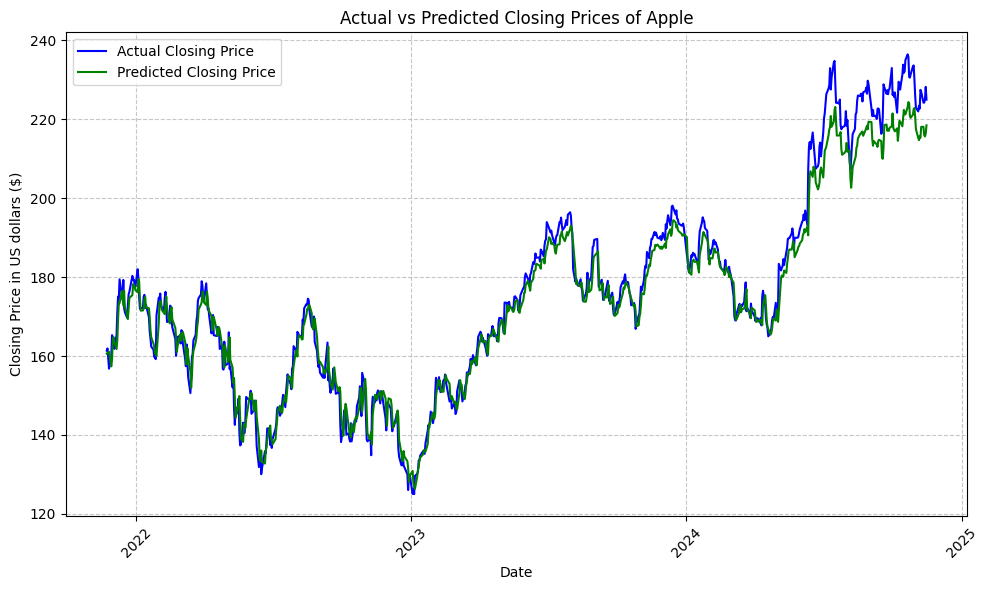

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Load data and convert 'Date' to datetime format
data = pd.read_csv('AAPL_30yrs.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Use only the 'Close' column for prediction
close_prices = data[['Close']]

# Standardize the close prices for better training performance
scaler = StandardScaler()
close_prices_scaled = scaler.fit_transform(close_prices)

# Define sequence length (e.g., 60 days of historical prices)
sequence_length = 60

# Create sequences and targets for the model
X = []
y = []
for i in range(sequence_length, len(close_prices_scaled)):
    X.append(close_prices_scaled[i-sequence_length:i])  # Last 60 days
    y.append(close_prices_scaled[i, 0])  # Next day's price

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X to (samples, time steps, features) for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Predict on test data
y_pred_scaled = model.predict(X_test)

# Reverse the standardization to get predictions in original scale
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled).flatten()

# Plot the actual vs. predicted values on test data
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][-len(y_test):], y_test_unscaled, label='Actual Closing Price', color='blue')
plt.plot(data['Date'][-len(y_test):], y_pred_unscaled, label='Predicted Closing Price', color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price in US dollars ($)')
plt.title("Actual vs Predicted Closing Prices of Apple")
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
